# Primary-Multiple Curvelet Separation: real data example

Since the bayesian separation produced better results than the masking, in this notebook we apply the routine to the real Voring dataset and measure effectiveness through auto-correlation.

*****

**IMPORTANT!**

You need to install curvelops inside the pylops_37 environment due to this package being compatible only with python 3.7. Please follow the instructions written in the github website: https://github.com/DIG-Kaust/conda_envs/blob/main/install_curvelops.sh

The .yml environment file can be found here:
https://github.com/DIG-Kaust/conda_envs/blob/main/environment_pylops_37.yml

Once complete, run this notebook using pylops_37 env.

*****

In [1]:
import matplotlib.pyplot as plt
import numpy as np

from curvelops import FDCT2D

import sys
sys.path.append('../adasubtraction/')     # add path to adasubtraction

from read_gathers import read_gathers
from adasubtraction_qc import adasubtraction_qc
from curvelet_separation import curvelet_separation

## Demultiple real data

Read the 2d shot gathers.

In [30]:
# Total data
filename = '../data/Voring/shots.inter.su'

data = read_gathers(filename)

In [7]:
# Import predicted multiples
filename = '../data/Voring/shots.multwav.su'

multiples = read_gathers(filename)

In [8]:
# Import corrected multiples by iterative SRME
filename = '../data/Voring/shots.srme.su'

srme_primaries = read_gathers(filename)

Plot and compare imported data.

In [10]:
ns = data.shape[0]
nr = data.shape[1]
nt = data.shape[2]

dt = 0.004 # s
dx = 25    # m

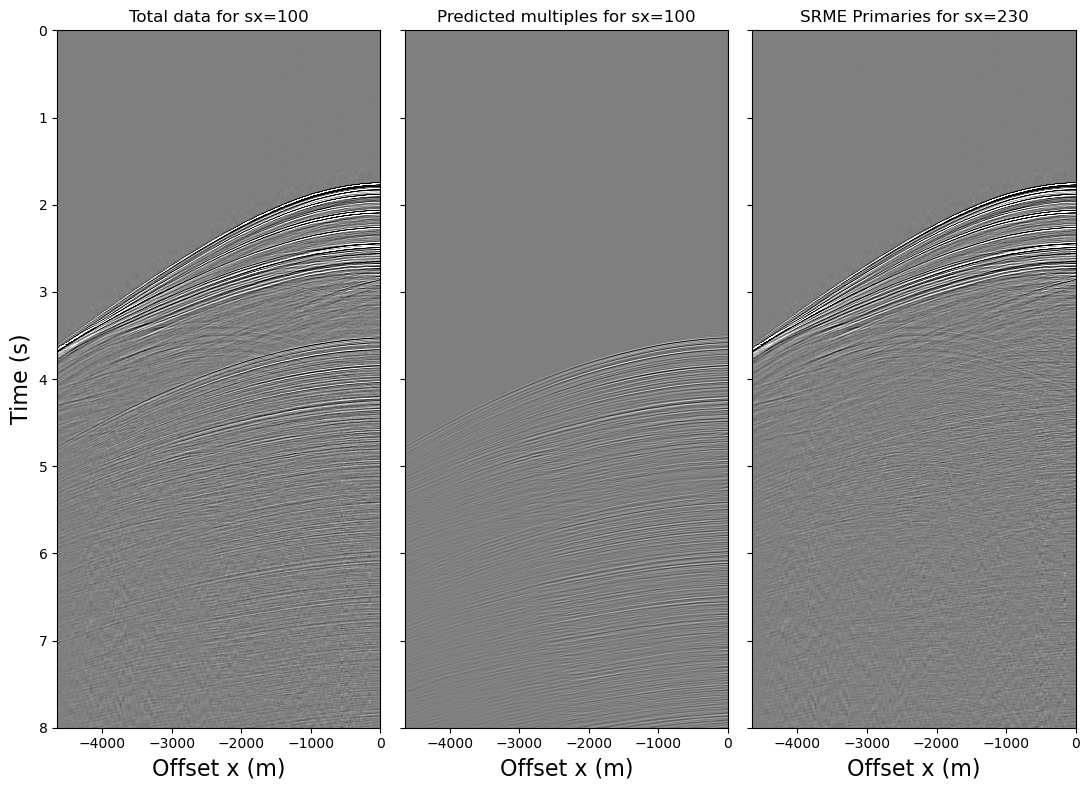

In [31]:
# Plot some imported CSG

vmax = 0.06 * np.amax(data)
vmin = -vmax

# Plotting parameters
t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = -nr * dx
xmax = 0

fig, axs = plt.subplots(1, 3, figsize=(11,8),sharey=True)
axs[0].imshow(data[100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Total data for sx=100',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples[100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Predicted multiples for sx=100',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme_primaries[100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Primaries for sx=230',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

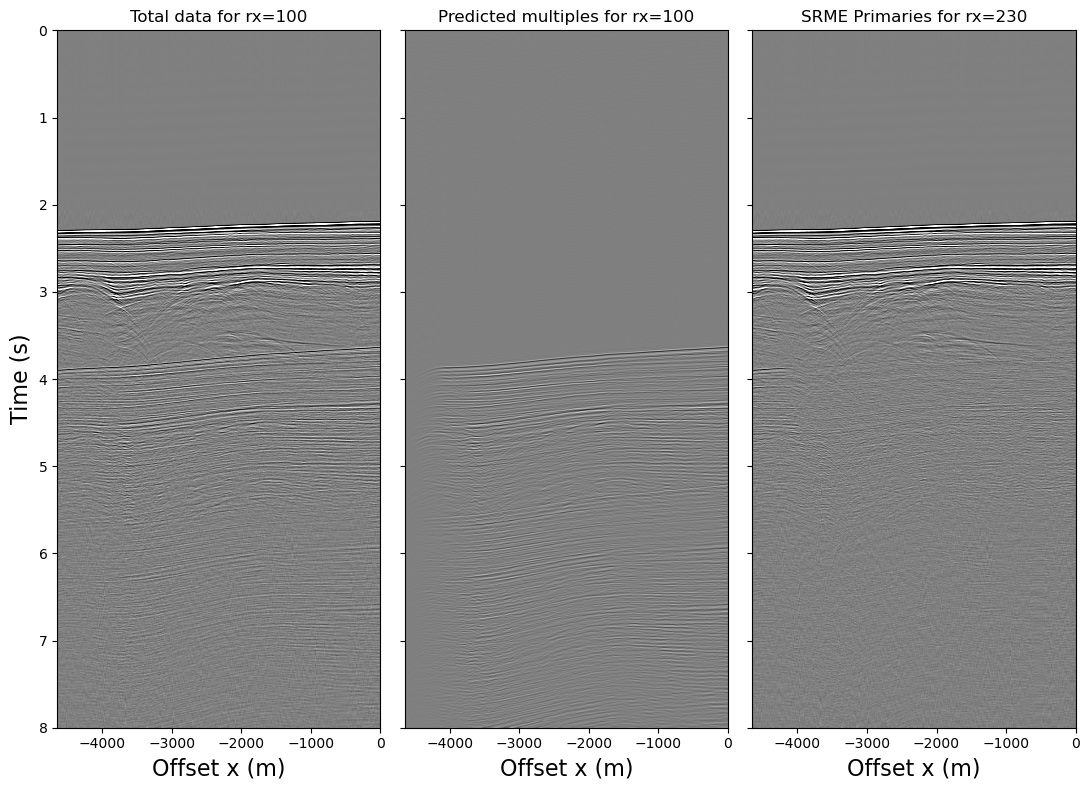

In [32]:
# Now plot CCG

t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = -nr * dx
xmax = 0

fig, axs = plt.subplots(1, 3, figsize=(11,8),sharey=True)
axs[0].imshow(data[:, 100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Total data for rx=100',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(multiples[:, 100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Predicted multiples for rx=100',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme_primaries[:, 100].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Primaries for rx=230',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

Now we apply the bayes separation in the curvelet domain and compare the obtained primaries with the SRME primaries.

In [20]:
# Select number of scales and wedges

sc = 10
w_n = 8

# Create Operator

C2D = FDCT2D(data[100].shape, nbscales=sc, nbangles_coarse=w_n, allcurvelets=False)

In [23]:
# Input parameters
eps1 = 1
eps2 = 0.1
eta = 1

# Apply bayes separation algorithm (Saab et al. 2007)
s1  = curvelet_separation(C2D, data[173], multiples[173], eps1, eps2, eta, niter=30)

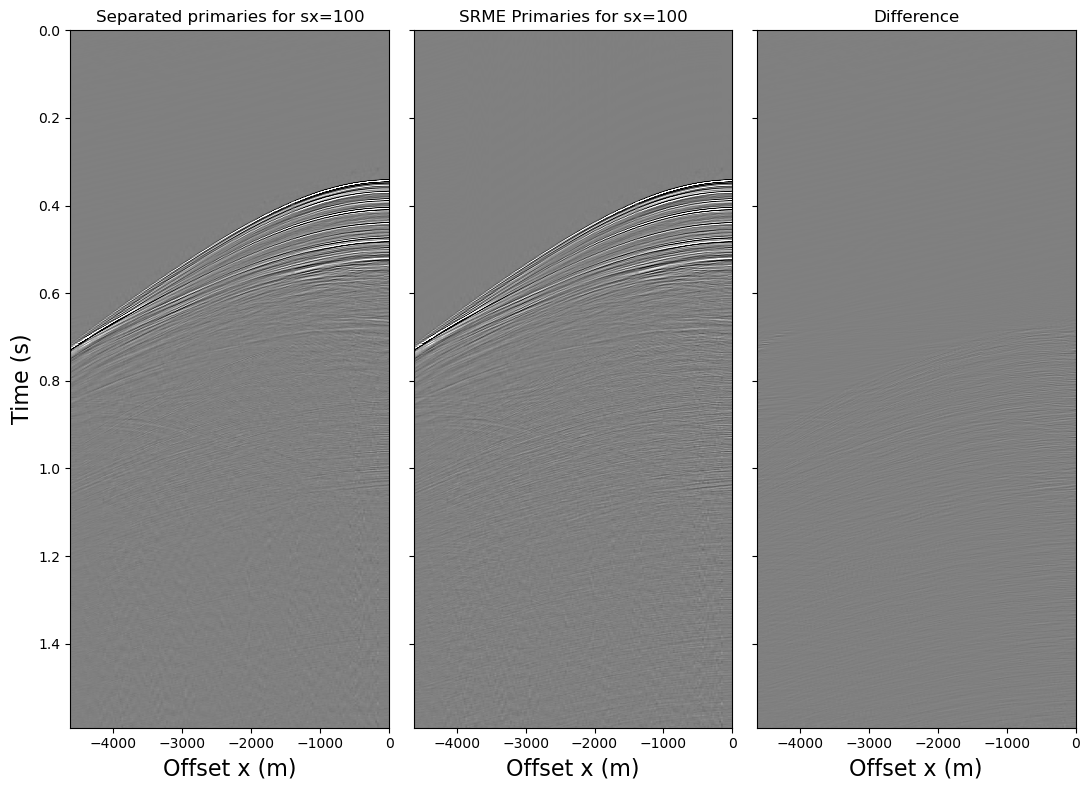

In [33]:
# Plotting parameters
vmax = 0.1 * np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (ns - 1) * dt
xmin = -4625
xmax = 0

fig, axs = plt.subplots(1, 3, figsize=(11,8),sharey=True)
axs[0].imshow(s1.T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Separated primaries for sx=100',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(srme_primaries[173].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'SRME Primaries for sx=100',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow((s1-srme_primaries[173]).T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'Difference',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

### QC using all shots
Similar as in adaptive subtraction, one way to measure the effectiveness in multiple removal is through auto-correlation in common channel gathers. 

In [26]:
separation_primaries = np.load('../data/separation_primaries.npz')['arr_0']

In [43]:
# Remove multiples from all shots 

separation_primaries = np.zeros_like(data)

for s in range(data.shape[0]):
    
    separation_primaries[s] = curvelet_separation(C2D, data[s], multiples[s], eps1, eps2, eta, niter=30)

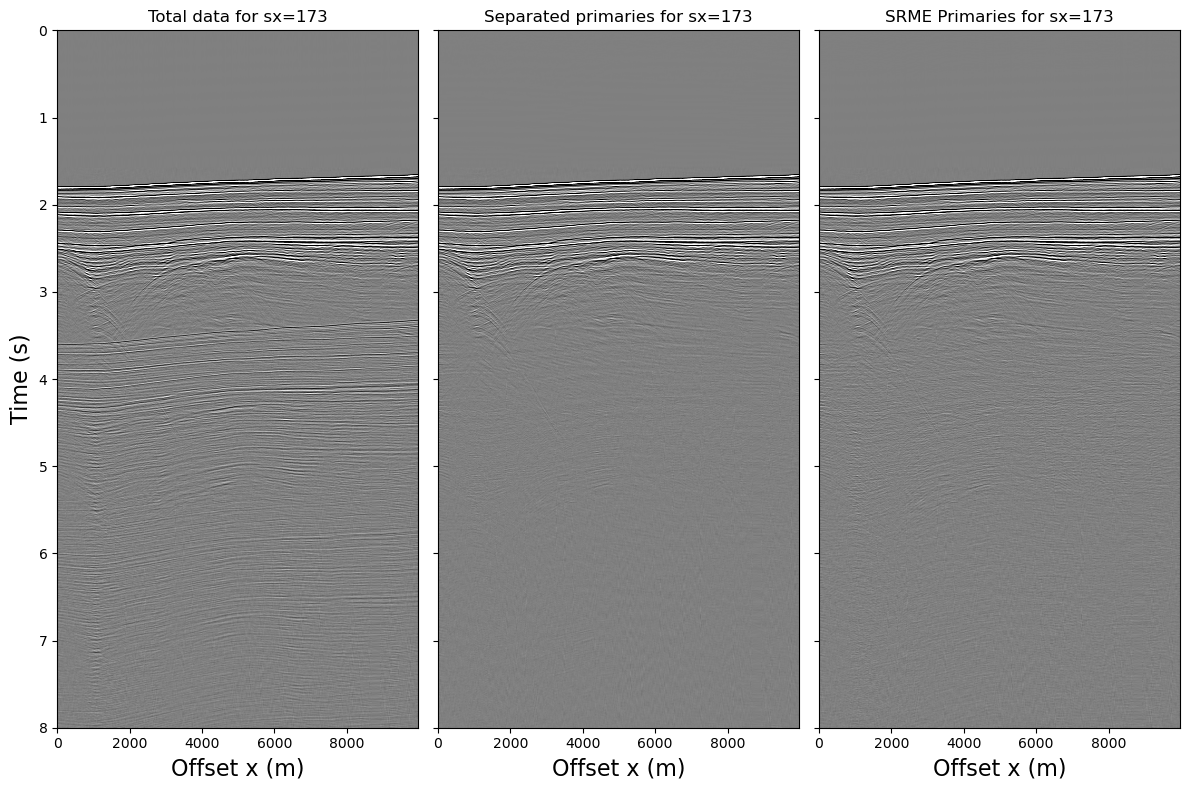

In [35]:
# Plot Common Channel Gathers of corrected primaries

# Plotting parameters
vmax = 0.1 * np.amax(data)
vmin = -vmax
t0 = 0.0
t1 = t0 + (nt - 1) * dt
xmin = 0
xmax = ns * dx

fig, axs = plt.subplots(1, 3, figsize=(12,8),sharey=True)
axs[0].imshow(data[:, 173].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[0].set_title(f'Total data for rx=173',fontsize=12)
axs[0].set_xlabel('Offset x (m)',fontsize=16)
axs[0].set_ylabel('Time (s)',fontsize=16)
axs[1].imshow(separation_primaries[:, 173].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[1].set_title(f'Separated primaries for rx=173',fontsize=12)
axs[1].set_xlabel('Offset x (m)',fontsize=16)
axs[2].imshow(srme_primaries[:, 173].T, aspect='auto', vmin=vmin, vmax=vmax, extent=[xmin,xmax,t1,t0], cmap='gray')
axs[2].set_title(f'SRME Primaries for rx=173',fontsize=12)
axs[2].set_xlabel('Offset x (m)',fontsize=16)

plt.tight_layout()

- SRME Primaries

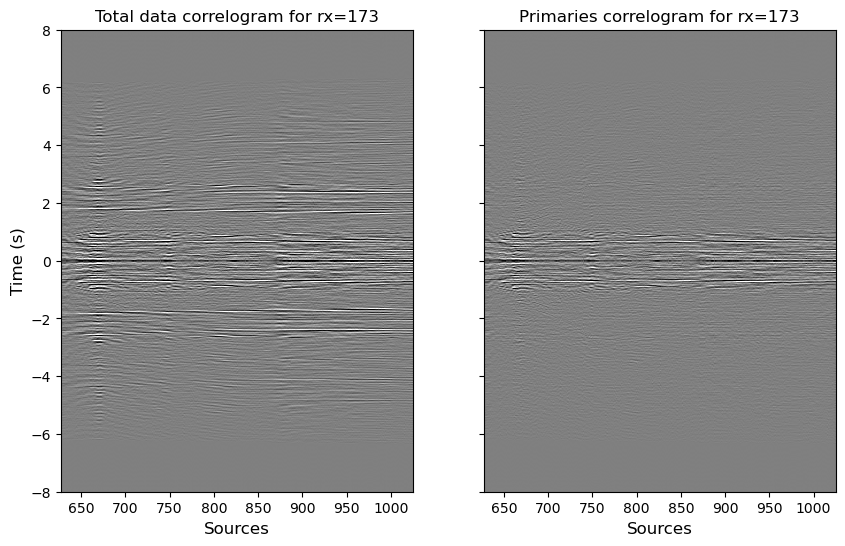

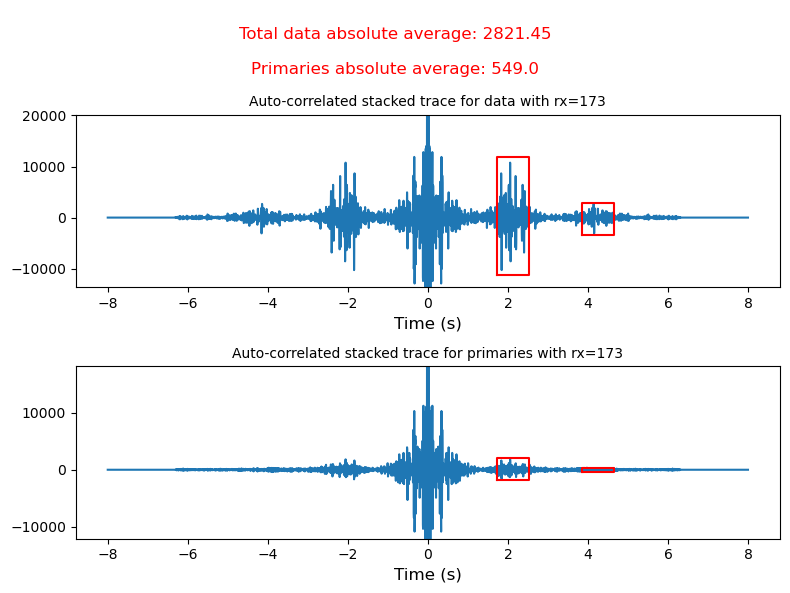

In [38]:
adasubtraction_qc(data, srme_primaries, gather_num=173)

- Separation Primaries

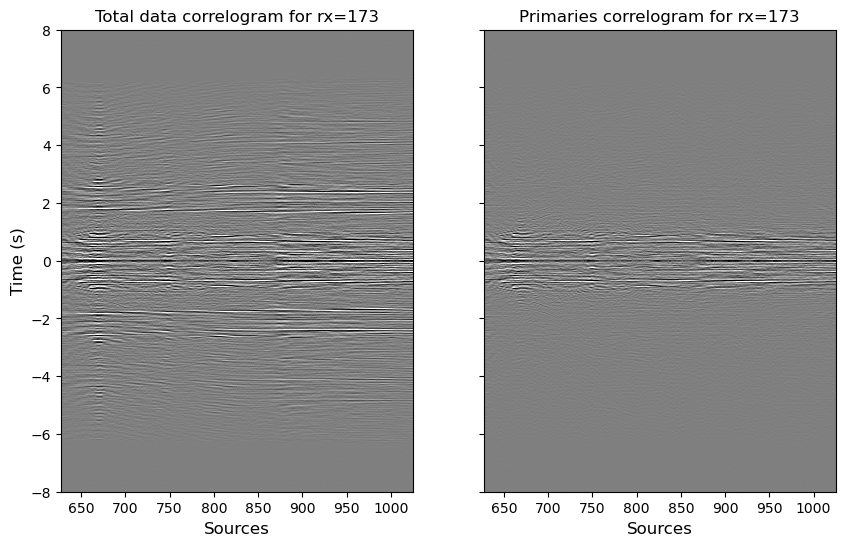

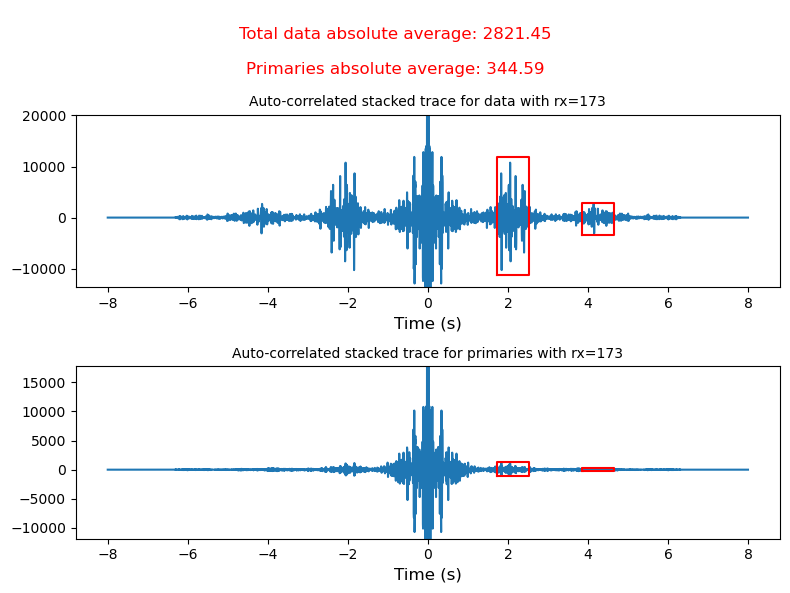

In [39]:
adasubtraction_qc(data, separation_primaries, gather_num=173)

The supression of multiples in the Voring data by the bayes separation algorithm clearly surpasses the iterative SRME, going from 549 to 345. These magnitudes correspond to the absolute amplitude average inside the windows where the first two strong multiples are found. Furthermore, common channel gathers plots show most of the primaries are kept intact for the separation output.